In [1]:
import os,sys
file_path = '../src/stacked_hourglass'
sys.path.append(os.path.dirname(file_path))

# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
from tqdm.notebook import trange, tqdm 

import torch
from torch.utils.data import DataLoader
from torch.nn import DataParallel
from torch.optim import Adam

from stacked_hourglass import hg2
from stacked_hourglass.utils.logger import Logger
from stacked_hourglass.datasets.mpii import Mpii
from stacked_hourglass.utils.misc import save_checkpoint, adjust_learning_rate
from stacked_hourglass.train import do_training_epoch, do_validation_epoch

In [3]:
image_path = 'C:/Users/wanglab/Downloads/mpii_human_pose_v1/images'
checkpoint = 'checkpoint'
input_shape = (256, 256)
arch = 'hg2'

train_batch = 32 #This works with my 12Gb video card, but probably need 16 batches for 8Gb (This is for HG2)
test_batch = 16

workers = 2

lr = 5e-4

start_epoch = 0
epochs = 10
snapshot = 0

best_acc = 0

device = torch.device('cuda', torch.cuda.current_device())

# Disable gradient calculations by default.
torch.set_grad_enabled(False)

# create checkpoint dir
os.makedirs(checkpoint, exist_ok=True)

if arch == 'hg1':
    model = hg1(pretrained=False)
elif arch == 'hg2':
    model = hg2(pretrained=False)
elif arch == 'hg8':
    model = hg8(pretrained=False)
else:
    raise Exception('unrecognised model architecture: ' + arch)

model = DataParallel(model).to(device)

#logger = Logger('log.txt')
#logger.set_names(['Epoch', 'LR', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc'])

train_dataset = Mpii(image_path, is_train=True, inp_res=input_shape)
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch, shuffle=True,
    num_workers=workers, pin_memory=True
)

val_dataset = Mpii(image_path, is_train=False, inp_res=input_shape)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch, shuffle=False,
    num_workers=workers, pin_memory=True
)

optimizer = Adam(model.parameters(), lr=lr)

print('The total size of the training set is ', len(train_loader)*train_batch)
print('The total size of the validation set is ', len(val_loader)*test_batch)

The total size of the training set is  22256
The total size of the validation set is  2960


In [ ]:
# train and eval
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

for epoch in trange(start_epoch, epochs, desc='Overall', ascii=True):

    # train for one epoch
    train_loss, train_acc = do_training_epoch(train_loader, model, device, Mpii.DATA_INFO,
                                                  optimizer,
                                                  acc_joints=Mpii.ACC_JOINTS)

    # evaluate on validation set
    valid_loss, valid_acc, predictions = do_validation_epoch(val_loader, model, device,
                                                                 Mpii.DATA_INFO, False,
                                                                 acc_joints=Mpii.ACC_JOINTS)

    # print metrics
    tqdm.write(f'[{epoch + 1:3d}/{epochs:3d}] lr={lr:0.2e} '
                   f'train_loss={train_loss:0.4f} train_acc={100 * train_acc:0.2f} '
                   f'valid_loss={valid_loss:0.4f} valid_acc={100 * valid_acc:0.2f}')

    # append logger file
    #logger.append([epoch + 1, lr, train_loss, valid_loss, train_acc, valid_acc])
    #logger.plot_to_file(os.path.join(checkpoint, 'log.svg'), ['Train Acc', 'Val Acc'])
    writer.add_scalar('Loss/train', train_loss,epoch)
    writer.add_scalar('Loss/test', valid_loss,epoch)
    writer.add_scalar('Accuracy/train',train_acc,epoch)
    writer.add_scalar('Accuracy/test',valid_acc,epoch)

    # remember best acc and save checkpoint
    is_best = valid_acc > best_acc
    best_acc = max(valid_acc, best_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': arch,
        'state_dict': model.state_dict(),
        'best_acc': best_acc,
        'optimizer' : optimizer.state_dict(),
    }, predictions, is_best, checkpoint=checkpoint, snapshot=snapshot)

Overall:   0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.0009, Acc:   5.20: 100%|###################################################| 1391/1391 [19:14<00:00,  1.21it/s]


[  1/ 10] lr=5.00e-04 train_loss=0.0009 train_acc=5.20 valid_loss=0.0005 valid_acc=11.60


In [4]:
import matplotlib.pyplot

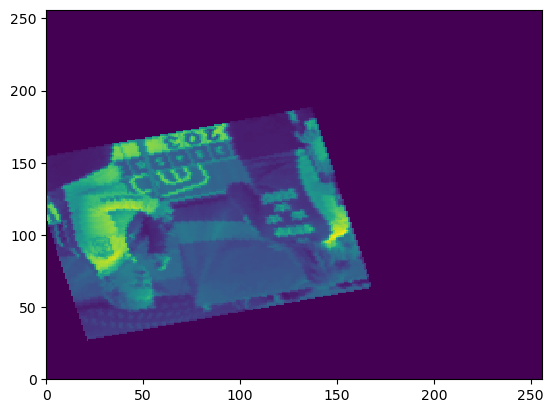

In [7]:
img,label,meta = train_dataset[4]
matplotlib.pyplot.pcolor(img[1,:,:])

#matplotlib.pyplot.pcolor(train_dataset[2][1][2,:,:])

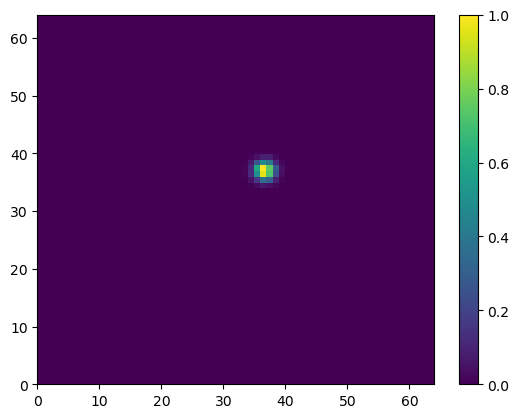

In [17]:
matplotlib.pyplot.pcolor(label[3,:,:])
matplotlib.pyplot.colorbar()

In [34]:
max_values = img.reshape(img.shape[0],-1).max(dim=-1,keepdim=True)[0]
out = img / max_values.unsqueeze(2)
out.size()

torch.Size([3, 256, 256])

In [35]:
img.size()

torch.Size([3, 256, 256])